In [186]:
from tjl_dense_numpy_tensor import *
import numpy as np
import matplotlib.pyplot as plt
import tosig
import time
import pandas as pd

### Initialize path

In [322]:
dim = 5
path = np.random.rand(10, dim)

### Define truncation level

In [323]:
trunc_level = 3

### Compute dimension of $V^{\otimes N+1}$

In [324]:
extension_dim = (tosig.sigdim(signal_dimension=dim, signature_degree=trunc_level+1) - 
                 tosig.sigdim(signal_dimension=dim, signature_degree=trunc_level))

# Computing signatures in 2 different ways

In [325]:
def compare_sig_computing_methods(path, trunc_level, sub_part):
    
    # Set partition mesh size
    interpolation = [path[0]]
    for a, b in zip(np.diff(path, axis=0)/float(sub_part), path[1:]):
        for k in range(sub_part-1):
            interpolation.append(interpolation[-1] + a)
        interpolation.append(b)
    interpolation = np.array(interpolation)

    t1 = time.time()
    # Compute truncated exp of single increments up to level N
    increments_exp = [stream2sigtensor(x, trunc_level) for x in [interpolation[i:i+2] for i in range(len(interpolation)-1)]]

    # Extend each increment multiplicative functional from level N to level N+1 by padding zeros
    extension_increments_exp = [np.concatenate((inc, np.zeros(extension_dim))) for inc in increments_exp]

    # Use Chen recursively on the extended increment functionals
    extension = extension_increments_exp[0]
    for j in extension_increments_exp[1:]:
        extension = tensor_multiply(extension, j, trunc_level+1)
    time_for_ext_sig = time.time() - t1

    t2 = time.time()
    # Compute signature in standard way
    real_sig = stream2sigtensor(path, trunc_level+1)
    time_for_standard_sig = time.time() - t2
    
    # Compute difference
    return np.array([np.abs(x) for x in (real_sig-extension)]), time_for_standard_sig, time_for_ext_sig

In [326]:
# Compute differences time series
differences = {}
for s in [2, 3, 5, 8, 10]:
    differences[f'subvide increment into {s} subincrements'],_,_ = compare_sig_computing_methods(path, trunc_level, sub_part=s)
df = pd.DataFrame.from_dict(differences)

# Compute cumulative absolute difference
diffs = []
xxx = []
time_diffs = []
yyy = []
for s in np.arange(2, 20):
    xxx.append('{:.2f}'.format(1./s))
    diff, sig_t, ext_t = compare_sig_computing_methods(path, trunc_level, sub_part=s)
    diffs.append(np.sum(diff))
    time_diffs.append(np.abs(sig_t - ext_t))
    yyy.append(s)

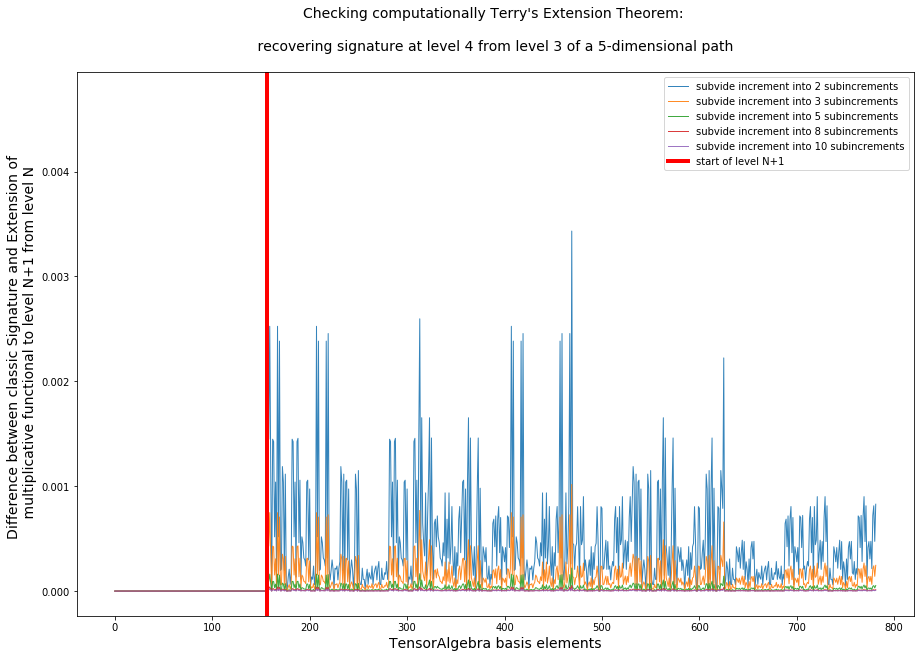

In [327]:
# PLotting
df.plot(label='Absolute Difference', alpha=0.9, lw=1, figsize=(15, 10), kind='line')
plt.xlabel('TensorAlgebra basis elements', size=14)
plt.ylabel('Difference between classic Signature and Extension of \n multiplicative functional to level N+1 from level N', 
           size=14)
plt.title("Checking computationally Terry's Extension Theorem: \n \n recovering signature at level {} from level {} of a {}-dimensional path \n".format(trunc_level+1, trunc_level, dim), 
          size=14)
plt.axvline(tosig.sigdim(signal_dimension=dim, signature_degree=trunc_level), color='red', lw=4, 
            label='start of level N+1')
plt.legend()
plt.show()

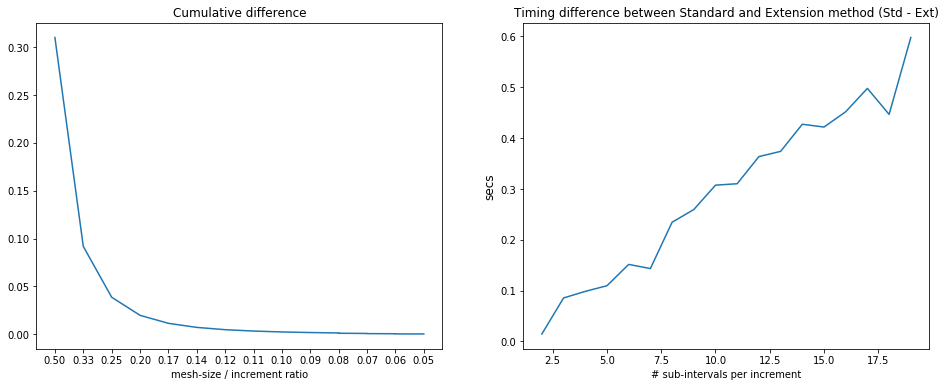

In [328]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(xxx, diffs)
ax[1].plot(yyy, time_diffs)
ax[0].set_title('Cumulative difference')
ax[1].set_title('Timing difference between Standard and Extension method (Std - Ext)')
ax[0].set_xlabel('mesh-size / increment ratio')
ax[1].set_ylabel('secs', size=12)
ax[1].set_xlabel('# sub-intervals per increment')
plt.subplots_adjust(wspace=0.2)
plt.show()